# Delineate catchments for all gauges in Germany

In this script, we use the [Global Watersheds delineator](https://github.com/mheberger/delineator) to delineate catchments for all measuring stations in `metadata.csv`.  

This script is based on the steps from the tutorial provided on the [Global Watersheds delineator](https://github.com/mheberger/delineator) Github page.

cite Global Watersheds delineator: 10.5281/zenodo.7314287 

## 0. Install delineator

It seems to be important to have the right versions of all required packages to make delineate.py work.  
So before executing this script, create a new `venv`, activate it and then run `pip install -r merit_hydro/delineator/requirements.txt`

In [1]:
from camelsp import get_metadata, Station

import os
import requests
import warnings
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

In [2]:
# create necessary directories
# folder for the downloaded data
datafolder = "../merit_hydro/data/"

# create the folder and subfolders if not exist
if not os.path.exists(datafolder):
    os.makedirs(datafolder)
    
    # folder for raster data
    os.makedirs(os.path.join(datafolder, "raster"))
    os.makedirs(os.path.join(datafolder, "raster", "accum_basins"))
    os.makedirs(os.path.join(datafolder, "raster", "flowdir_basins"))

    # folder for vector data
    os.makedirs(os.path.join(datafolder, "shp"))
    os.makedirs(os.path.join(datafolder, "shp", "merit_catchments"))
    os.makedirs(os.path.join(datafolder, "shp", "merit_rivers"))
    os.makedirs(os.path.join(datafolder, "shp", "catchments_simplified"))

## 1. Download MERIT-Hydro raster data

In [5]:
# download basin-scale MERIT-Hydro raster data (mghydro.com)
url_accum = ["https://mghydro.com/watersheds/rasters/accum_basins/accum22.tif",
             "https://mghydro.com/watersheds/rasters/accum_basins/accum23.tif",
             "https://mghydro.com/watersheds/rasters/accum_basins/accum24.tif"]

url_flow = ["https://mghydro.com/watersheds/rasters/flow_dir_basins/flowdir22.tif",
            "https://mghydro.com/watersheds/rasters/flow_dir_basins/flowdir23.tif",
            "https://mghydro.com/watersheds/rasters/flow_dir_basins/flowdir24.tif"]

# folder for the downloaded data
folder = "../merit_hydro/data/raster/"

for url in url_accum + url_flow:
    # download the file from the URL
    response = requests.get(url)

    if response.status_code == 200:
        # build the filename
        if url in url_accum:
            filename = os.path.join(folder, "accum_basins", os.path.basename(url))
        elif url in url_flow:
            filename = os.path.join(folder, "flowdir_basins", os.path.basename(url))
        
        # save the downloaded data to a file
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Data downloaded and saved to {filename}")
    else:
        print(f"Failed to download data. Status code: {response.status_code}")

Data downloaded and saved to ../merit_hydro/data/raster/accum_basins/accum22.tif
Data downloaded and saved to ../merit_hydro/data/raster/accum_basins/accum23.tif
Data downloaded and saved to ../merit_hydro/data/raster/accum_basins/accum24.tif
Data downloaded and saved to ../merit_hydro/data/raster/flowdir_basins/flowdir22.tif
Data downloaded and saved to ../merit_hydro/data/raster/flowdir_basins/flowdir23.tif
Data downloaded and saved to ../merit_hydro/data/raster/flowdir_basins/flowdir24.tif


## 2. Download MERIT-Basins vector data

Vector data is stored on Google Drive, so we download the data manually from https://www.reachhydro.org/home/params/merit-basins.

In the folder pfaf_level_02 , download two sets of files:

- unit catchment shapefiles: 
    - `cat_pfaf_22_MERIT_Hydro_v07_Basins_v01.shp` -> `../data/shp/merit_catchments`  
    - `cat_pfaf_23_MERIT_Hydro_v07_Basins_v01.shp` -> `../data/shp/merit_catchments`
    - `cat_pfaf_24_MERIT_Hydro_v07_Basins_v01.shp` -> `../data/shp/merit_catchments`
- river flowline shapefiles: 
    - `riv_pfaf_22_MERIT_Hydro_v07_Basins_v01.shp` -> `../data/shp/merit_rivers`
    - `riv_pfaf_23_MERIT_Hydro_v07_Basins_v01.shp` -> `../data/shp/merit_rivers`
    - `riv_pfaf_24_MERIT_Hydro_v07_Basins_v01.shp` -> `../data/shp/merit_rivers`

## 3. Download simplified MERIT-Basins data

In [6]:
url = "https://mghydro.com/watersheds/share/catchments_simplified.zip"

# folder for the downloaded data
folder = "../merit_hydro/data/shp/catchments_simplified/"

# download the file from the URL
response = requests.get(url)

if response.status_code == 200:
    # build the filename
    filename = os.path.join(folder, os.path.basename(url))

    # save the downloaded data to a file
    with open(filename, "wb") as file:
        file.write(response.content)
    print(f"Data downloaded and saved to {filename}")
else:
    print(f"Failed to download data. Status code: {response.status_code}")

# unzip
with zipfile.ZipFile(filename, 'r') as zip:
    zip.extractall(folder)

# remove zip file
os.remove(filename)

Data downloaded and saved to ../merit_hydro/data/shp/catchments_simplified/catchments_simplified.zip


## 4. Create a CSV file with your desired watershed outlet points

We create the watershed outlet points csv from `metadata.csv`.  

Required columns and mapping to camels metadata:
- `id` -> provider_id
- `lat` -> lat
- `lng` -> lon  

Optional columns:
- `name` -> gauge_name
- `area` -> area

In [3]:
# get CAMELS metadata
meta = get_metadata()

# select columns
outlets = meta[["camels_id", "lat", "lon", "gauge_name", "area"]].copy()

# rename columns
outlets.columns = ["id", "lat", "lng", "name", "area"]

# currently, not all rows are filled (e.g. some stations do not have lat and lon), remove those stations
outlets = outlets.dropna().reset_index(drop=True)

# drop lat and lon when infinity
outlets = outlets[(outlets["lat"] != np.inf) & (outlets["lng"] != np.inf)].reset_index(drop=True)

# replace -999.0 in column area with nan
outlets["area"] = outlets["area"].replace(-999.0, np.nan)

# save as csv
outlets.to_csv('../merit_hydro/data/outlets.csv', index=False)


## 5. Update config.py

This step can be omitted once the catchment delineation is set up.

## 6. Run delineator.py to delineate watersheds

In [33]:
# create output dir if not exist
if not os.path.exists("../merit_hydro/output"):
    os.makedirs("../merit_hydro/output")

# create plots dir if not exist
if not os.path.exists("../merit_hydro/delineator/plots"):
    os.makedirs("../merit_hydro/delineator/plots")

In [34]:
# takes around 15 mins for all stations
!cd ../merit_hydro && python delineate.py

/home/alexd/Projekte/CAMELS/Github/camelsp/.venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/alexd/Projekte/CAMELS/Github/camelsp/.venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
Reading your outlets data in: data/outlets.csv
Finding out which Level 2 megabasin(s) your points are in
Your watershed outlets are in 3 basin(s)

Beginning delineation for 426 outlet point(s) in Level 2 Basin #22.
Reading geodata in data/shp/merit_catchments/cat_pfaf_22_MERIT_Hydro_v07_Basins_v01.shp
Reading data table for rivers in basin 22
Reading geodata in data/shp/merit_rivers/riv_pf

## Save geojson to Station output folder

In [8]:
# get metadata
outlets = pd.read_csv("../merit_hydro/data/outlets.csv")

# create a list of camels ids
camels_ids = meta["camels_id"].tolist()

for camels_id in camels_ids:
    try:
        # initiate Station
        s = Station(camels_id)

        # read geojson file
        gdf = gpd.read_file(f"../merit_hydro/output/{camels_id}.geojson")

        # save geojson to Station output folder
        s.save_catchment_geometry(gdf, datasource='merit_hydro')

    except Exception as e:
        print(f"{camels_id} --- Error: {e}")


DEF10750 --- Error: ../merit_hydro/output/DEF10750.geojson: No such file or directory
DEF11140 --- Error: ../merit_hydro/output/DEF11140.geojson: No such file or directory
DEF11150 --- Error: ../merit_hydro/output/DEF11150.geojson: No such file or directory
DEF11160 --- Error: ../merit_hydro/output/DEF11160.geojson: No such file or directory
DEF11170 --- Error: ../merit_hydro/output/DEF11170.geojson: No such file or directory
DEF11400 --- Error: ../merit_hydro/output/DEF11400.geojson: No such file or directory
DEF11680 --- Error: ../merit_hydro/output/DEF11680.geojson: No such file or directory
DEF11690 --- Error: ../merit_hydro/output/DEF11690.geojson: No such file or directory
DEF11700 --- Error: ../merit_hydro/output/DEF11700.geojson: No such file or directory
DEF12430 --- Error: ../merit_hydro/output/DEF12430.geojson: No such file or directory
DEF12570 --- Error: ../merit_hydro/output/DEF12570.geojson: No such file or directory
DEF12910 --- Error: ../merit_hydro/output/DEF12910.geo

## Check for holes in catchments

Here we check for holes in the catchment geometry and fill them.  
We just fill by using the exterior of the Polygon with a gap as the new catchment geometry.

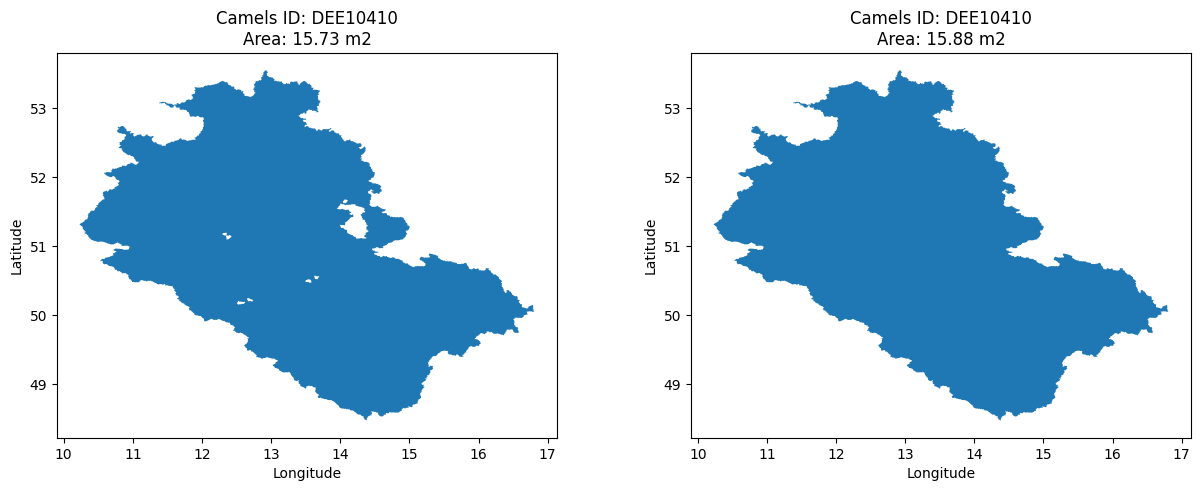

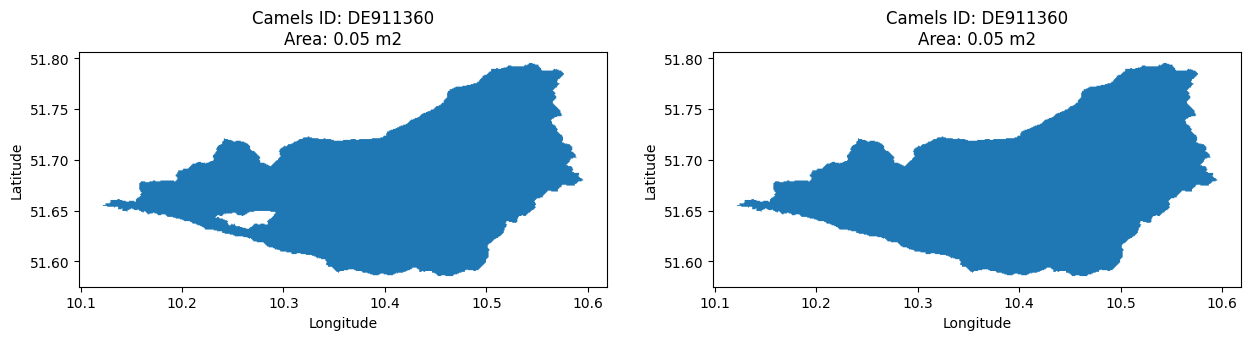

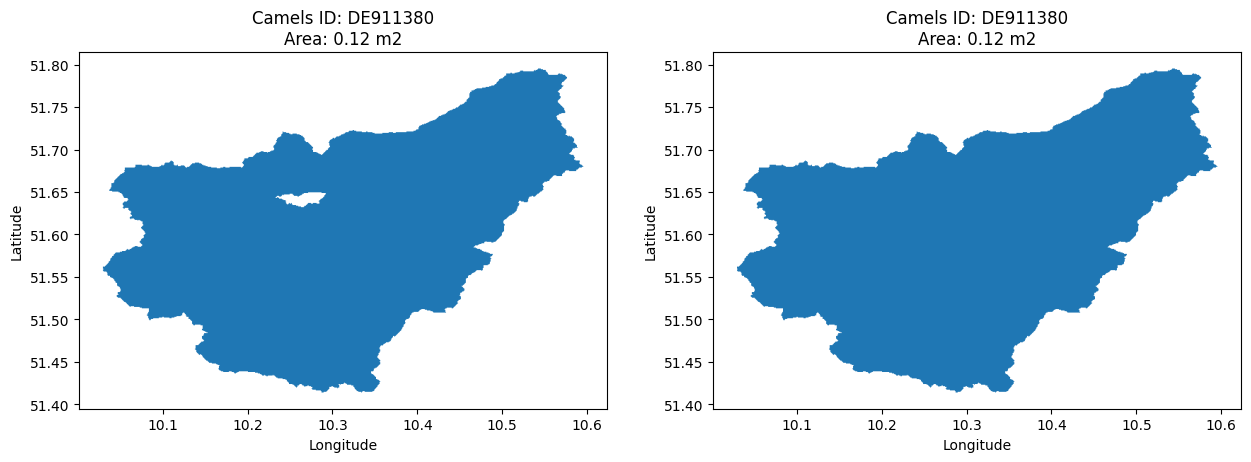

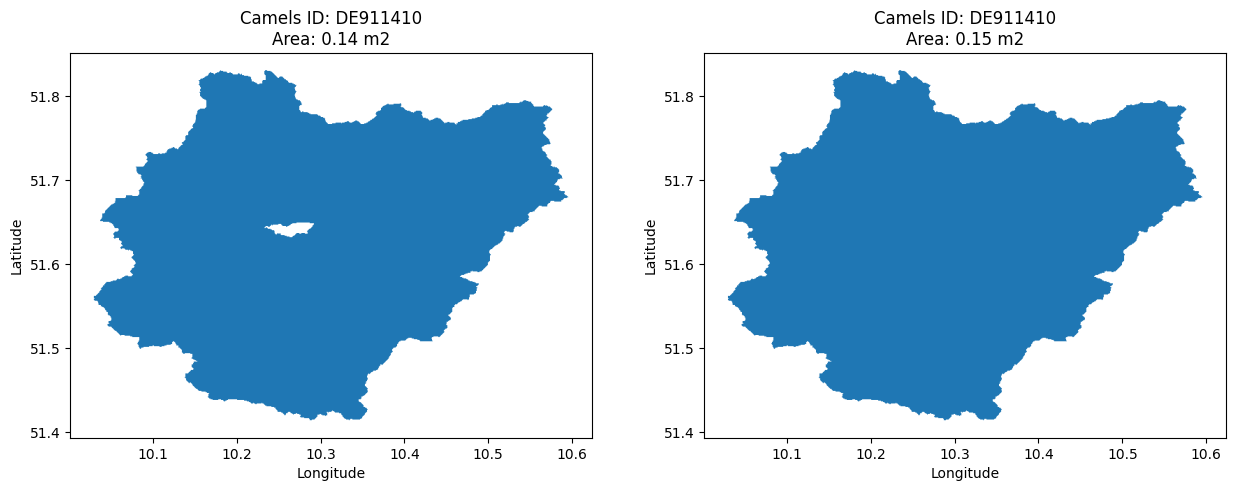

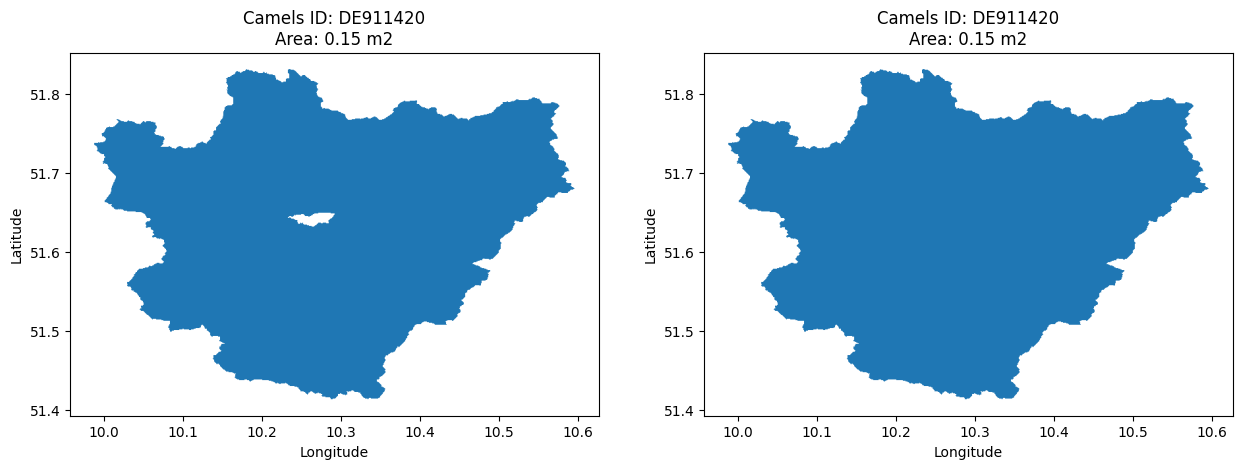

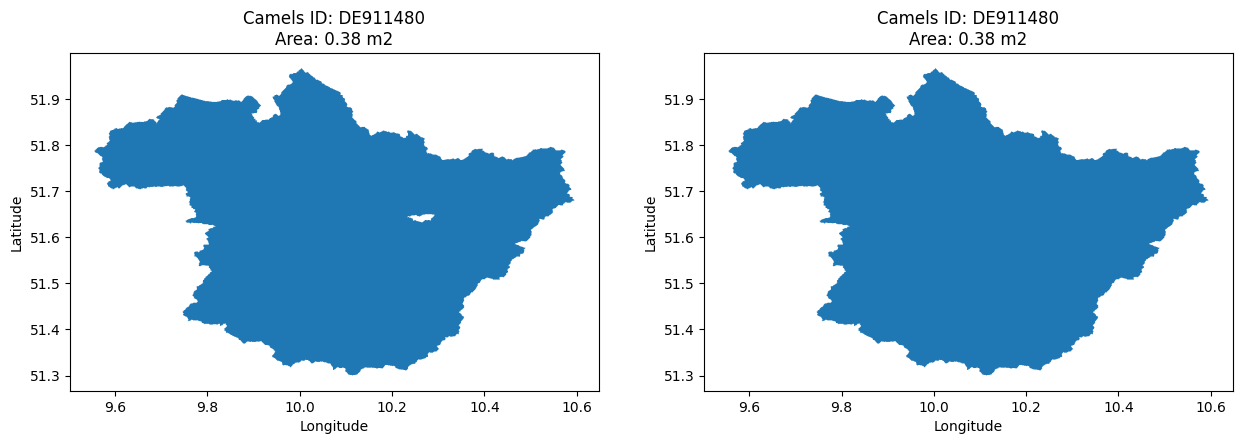

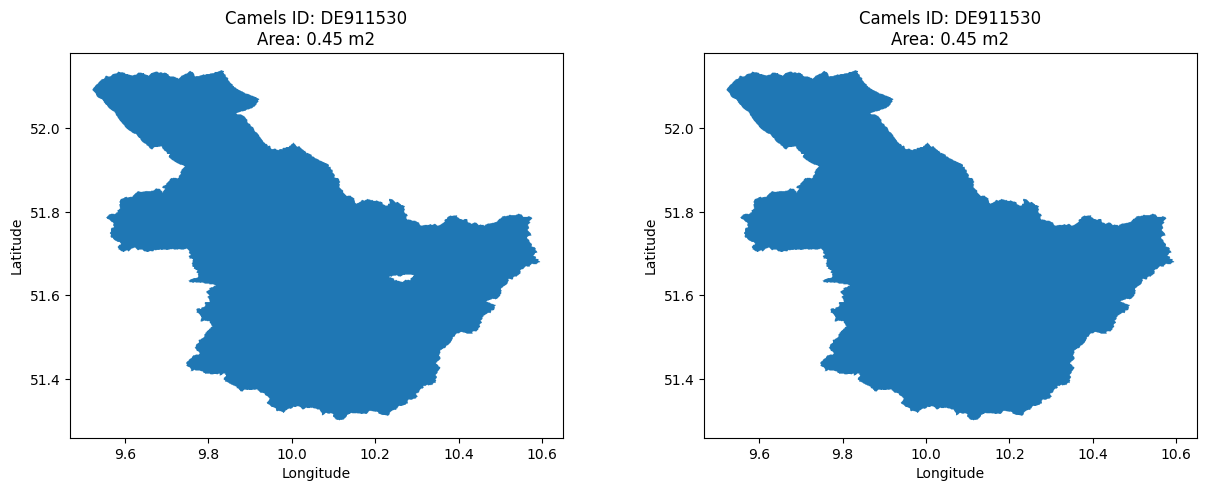

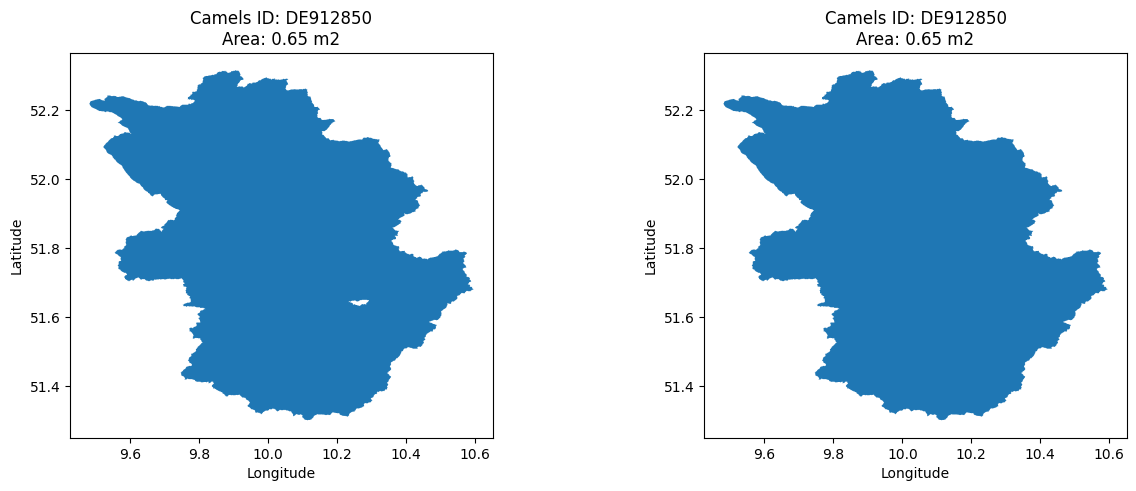

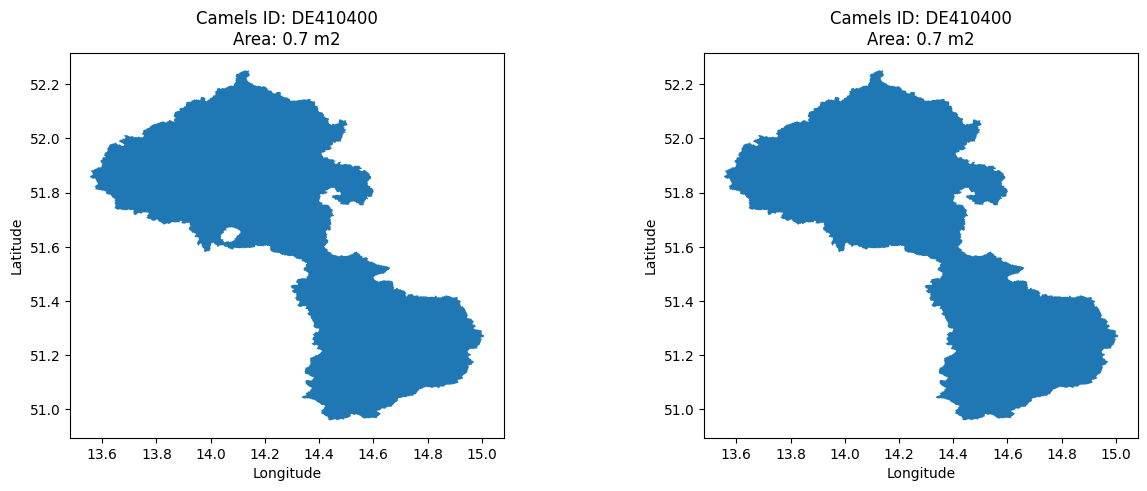

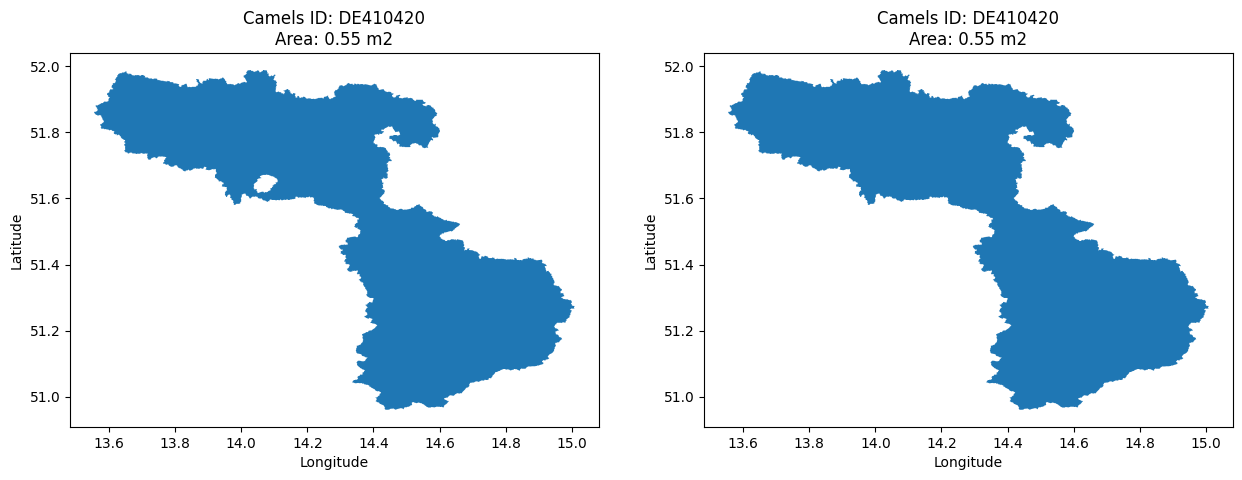

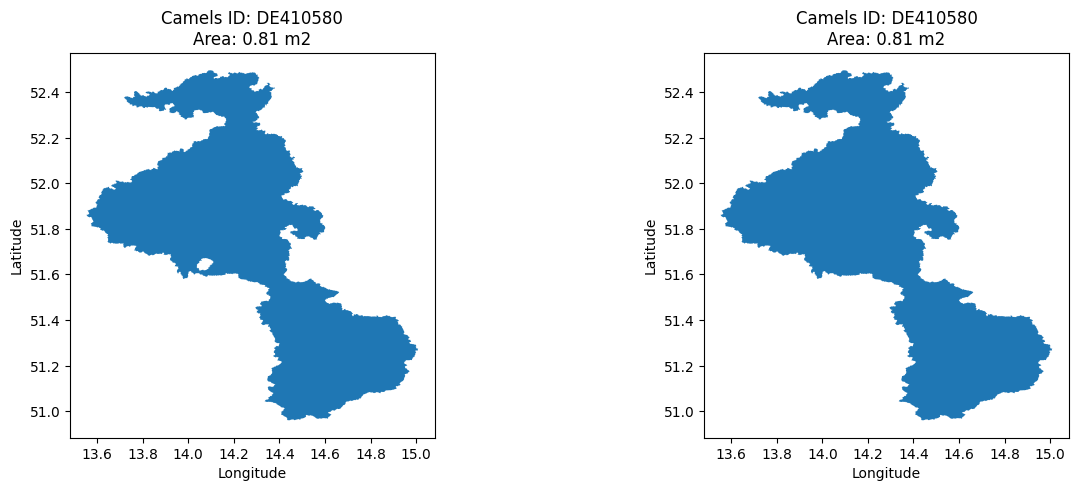

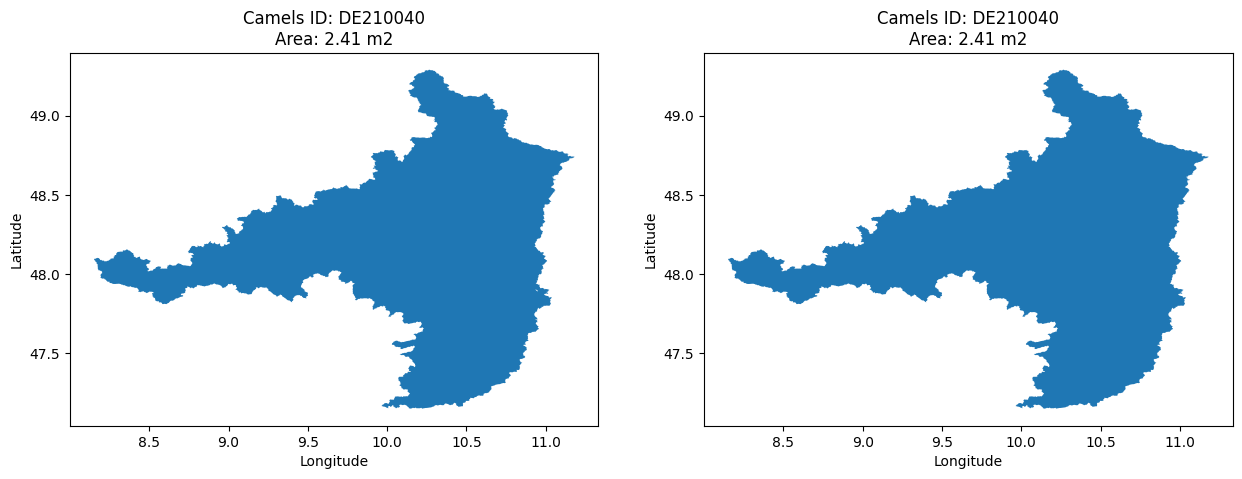

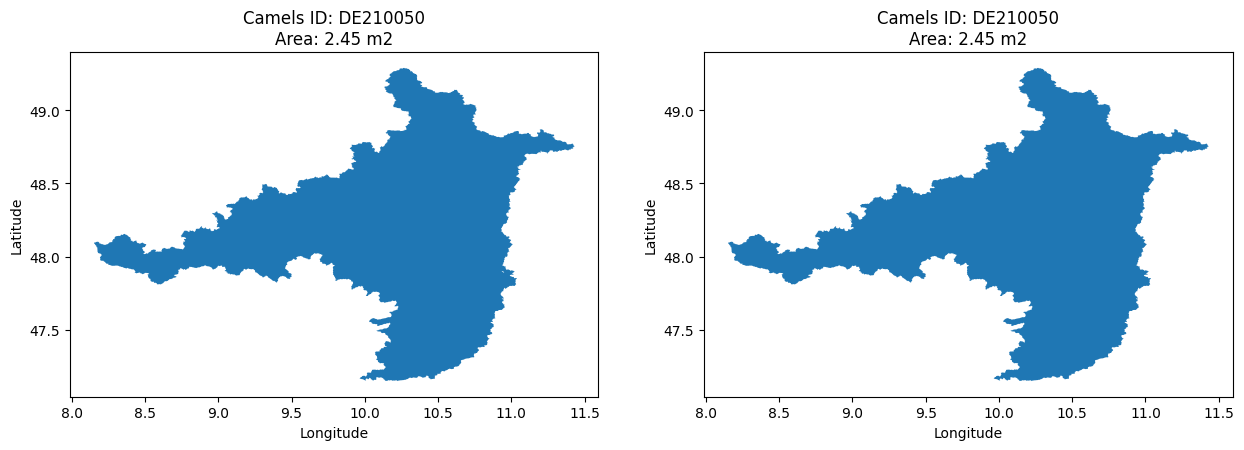

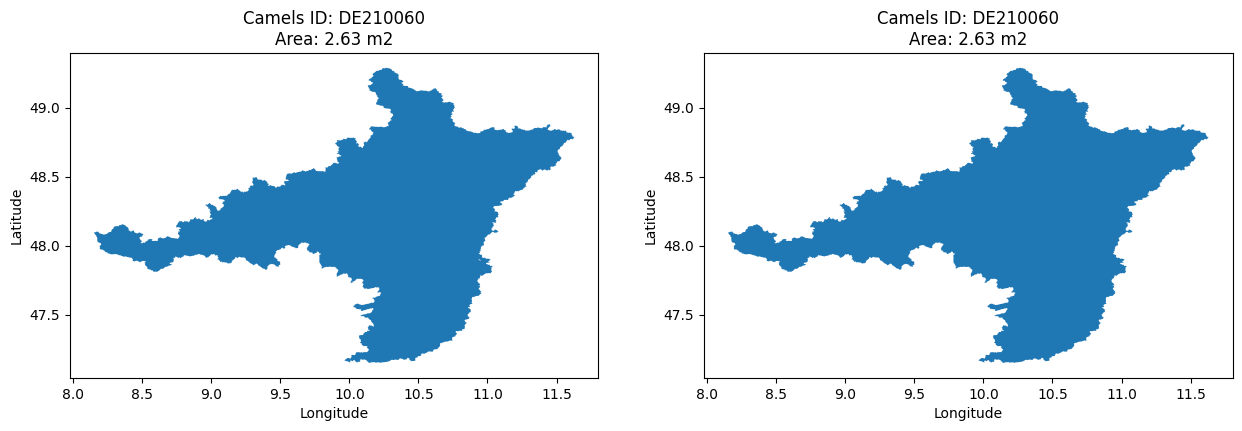

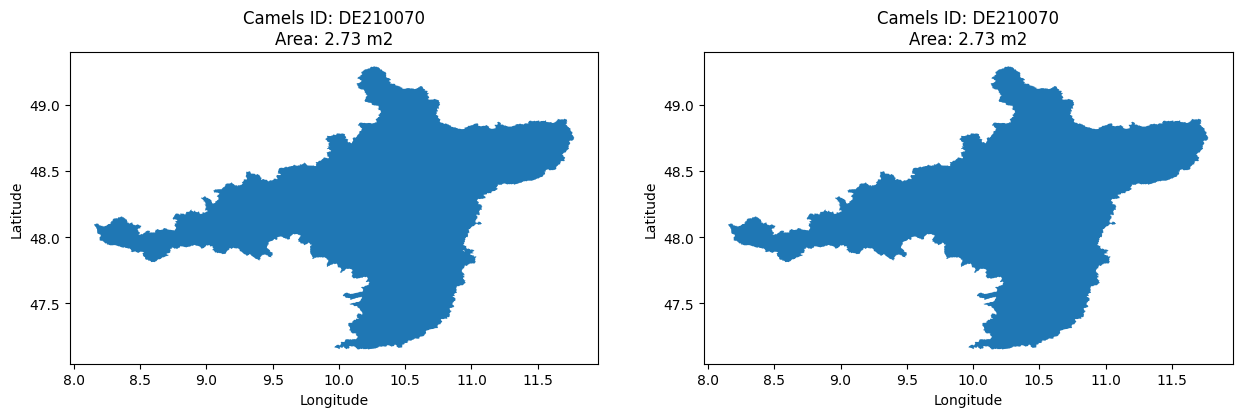

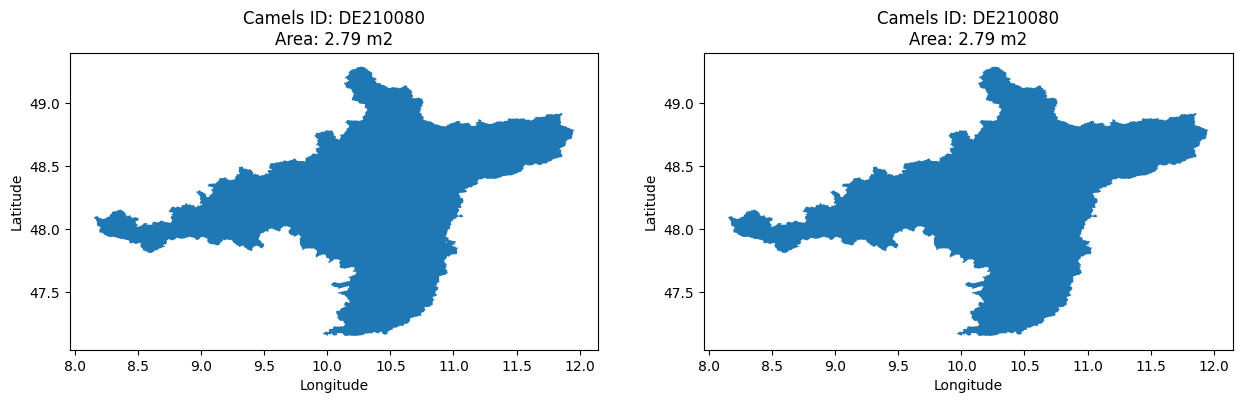

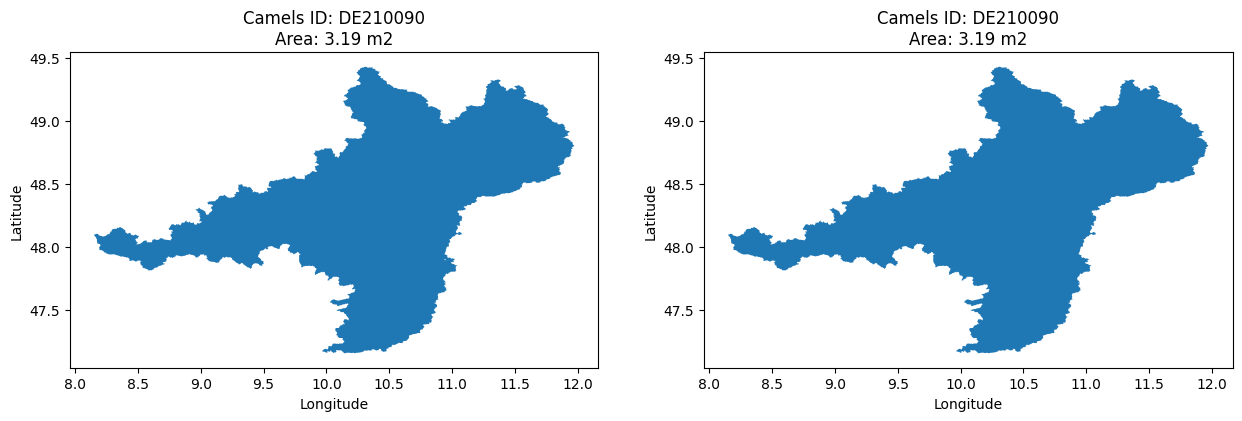

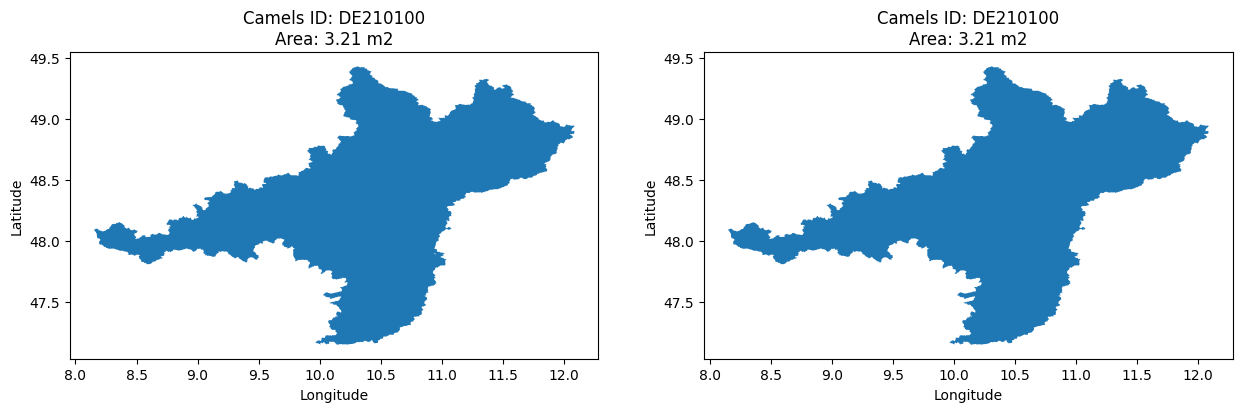

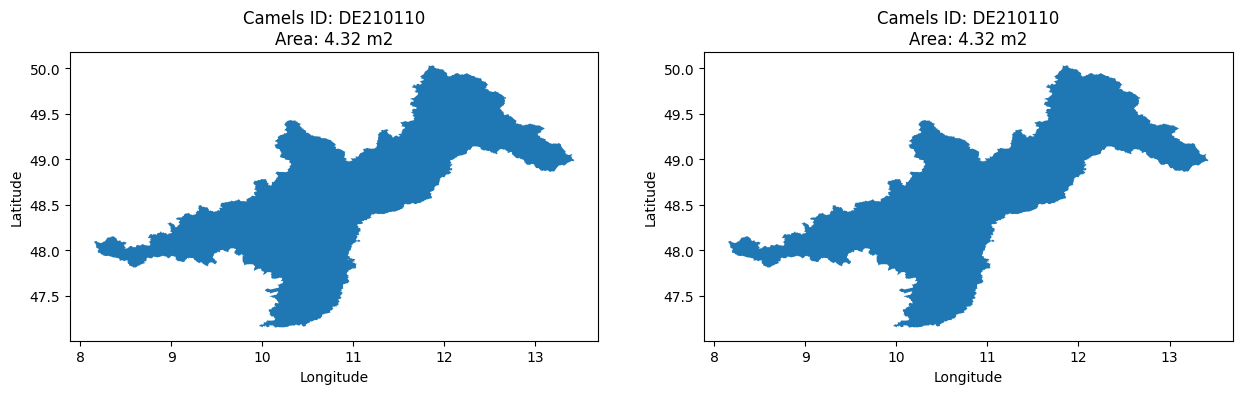

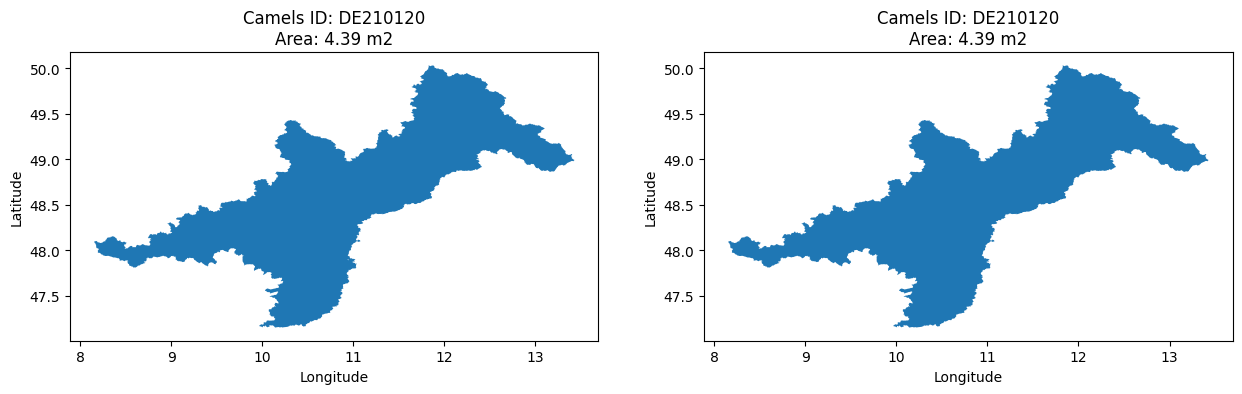

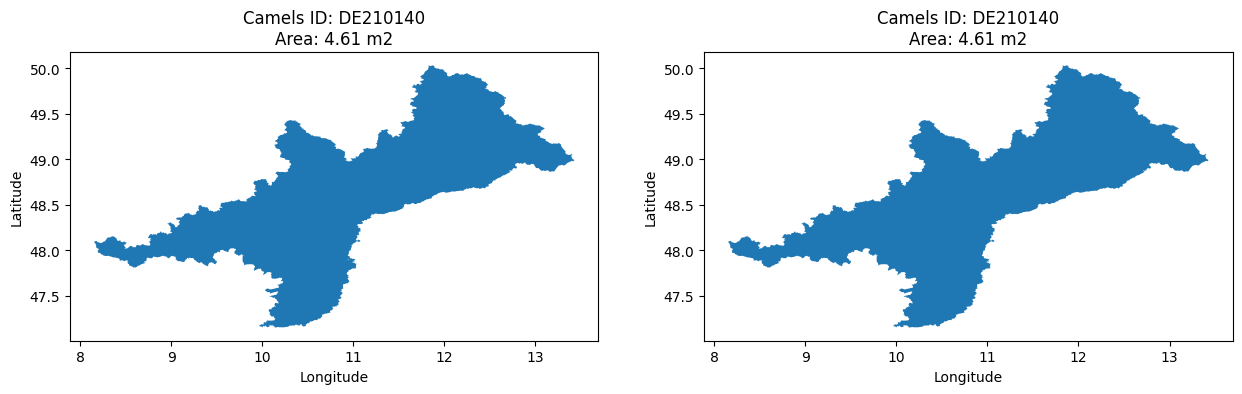

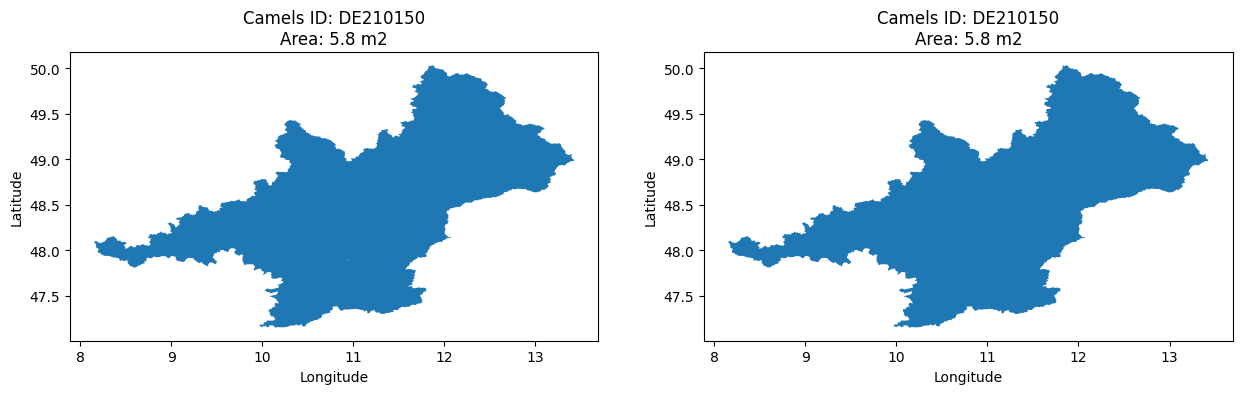

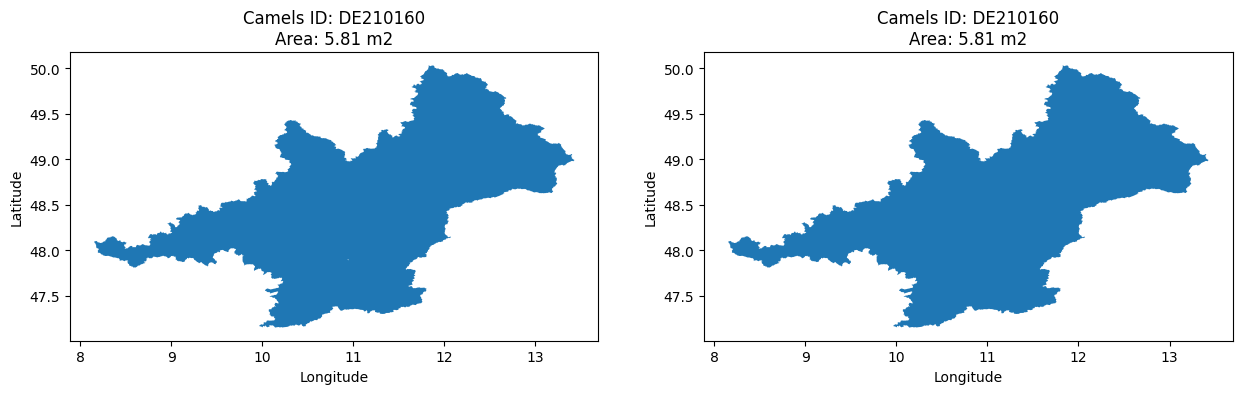

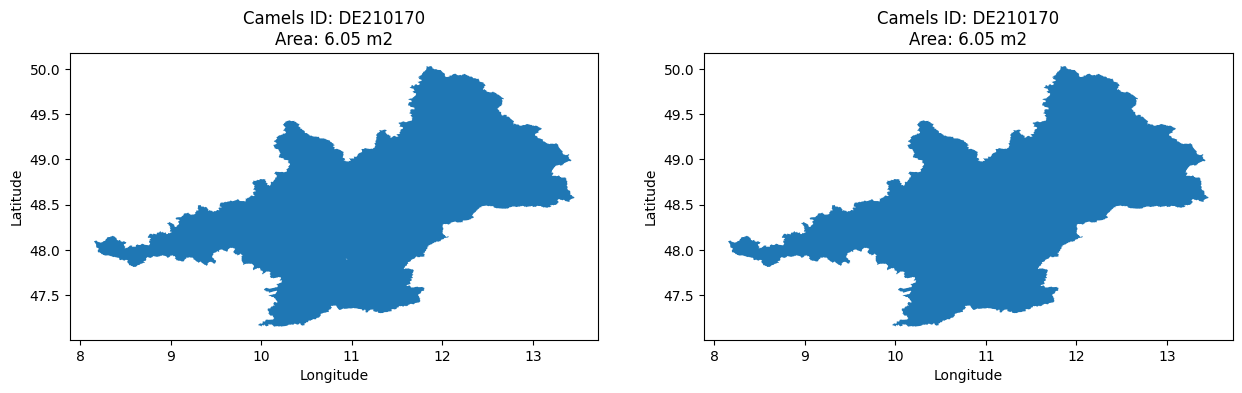

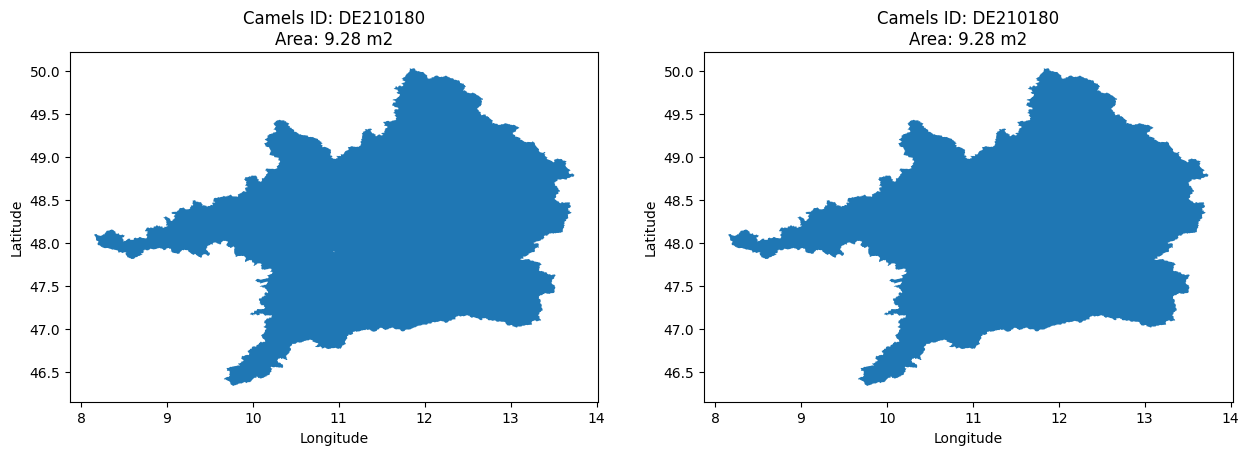

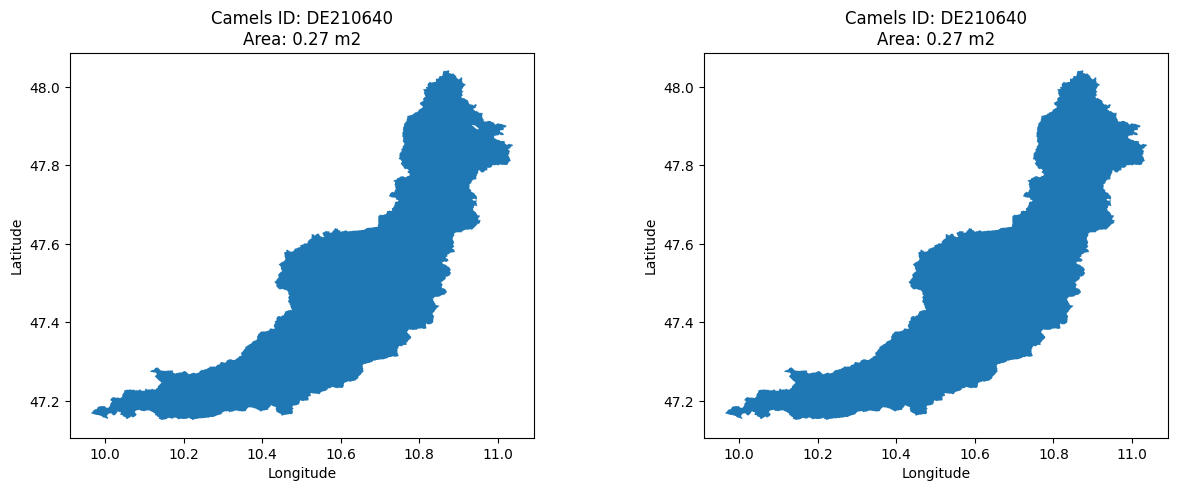

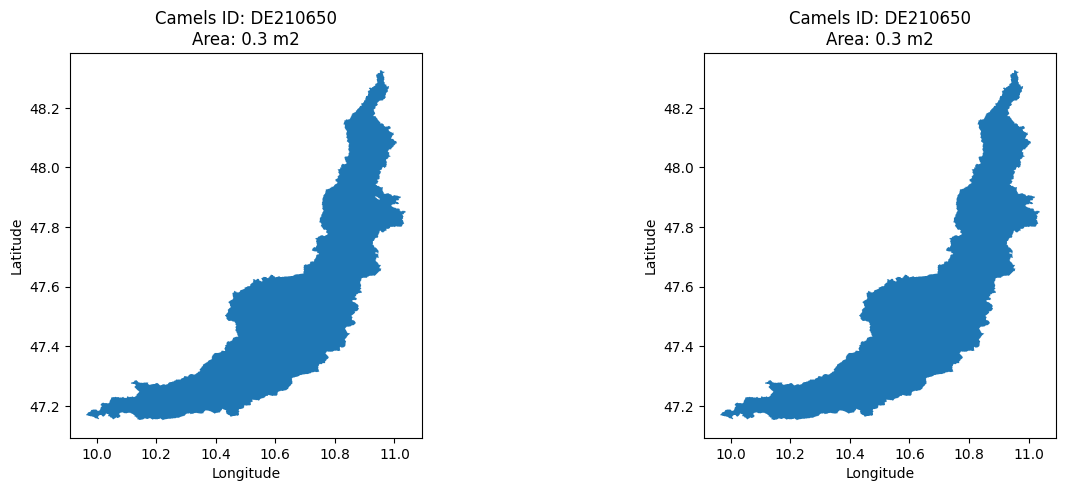

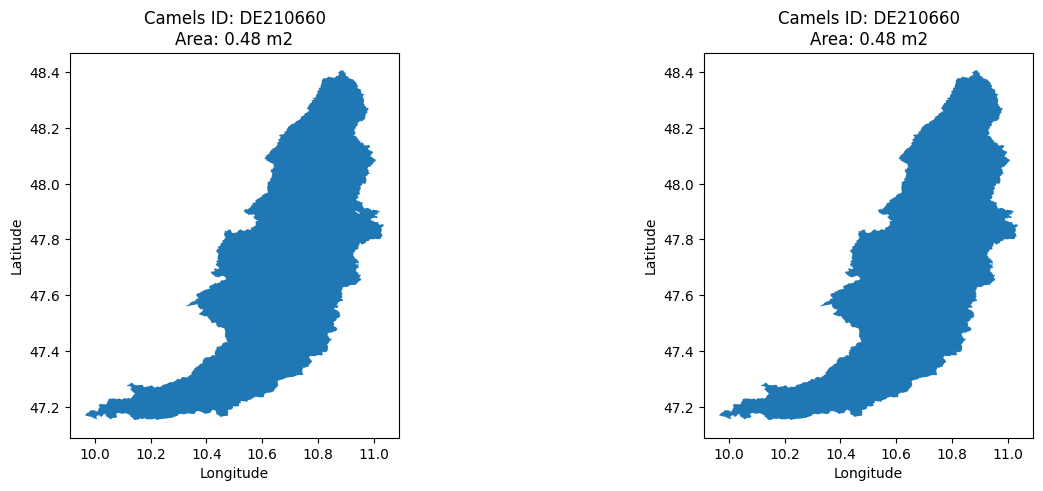

In [135]:
# get camels_ids
camels_ids = get_metadata()["camels_id"].values

ids_hole = []

new_area = None

for camels_id in camels_ids:
    # initialize station
    s = Station(camels_id)

    # get merit hydro catchment
    gdf = s.get_catchment("merit_hydro")

    if isinstance(gdf, gpd.GeoDataFrame):
        # check for interiors -> holes
        if len(gdf.geometry.iloc[0].interiors) > 0:
            ids_hole.append(camels_id)
            
            # ignore warnings when calculating area for geographic CRS
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                area_old = gdf.area[0]
                area_holes = sum([Polygon(i).area for i in gdf.geometry.iloc[0].interiors])

                # use exterior coords to create a new polygon without holes
                new_geom = Polygon(gdf.exterior[0].coords)

                area_new = new_geom.area

            # check if the area of the new polygon is almost the same as the area of the old polygon + the area of the holes
            assert np.isclose(area_new, area_old + area_holes, rtol=1e-2)

            # plot the old and new polygon to check if the holes are filled correctly
            fig, ax = plt.subplots(1, 2, figsize=(15, 5))

            gdf.plot(ax=ax[0], aspect='equal')
            ax[0].set_title(f"Camels ID: {camels_id}\nArea: {round(area_old, 2)} m2")
            ax[0].set_xlabel("Longitude")
            ax[0].set_ylabel("Latitude")

            gpd.GeoDataFrame(geometry=[new_geom]).plot(ax=ax[1], aspect='equal')
            ax[1].set_title(f"Camels ID: {camels_id}\nArea: {round(area_new, 2)} m2")
            ax[1].set_xlabel("Longitude")
            ax[1].set_ylabel("Latitude")

            plt.show()

            # replace the old geometry with the new geometry
            gdf["geometry"] = new_geom

            # save the new geometry to the output folder
            s.save_catchment_geometry(gdf, datasource='merit_hydro', if_exists='replace')
        

In [136]:
# additionaly, compile a geopackage with all catchments
camels_ids = get_metadata()["camels_id"].values

# create a list of geodataframes
gdfs = []

for camels_id in camels_ids:
    # initialize station
    s = Station(camels_id)

    # get merit hydro catchment
    gdf = s.get_catchment("merit_hydro")

    if isinstance(gdf, gpd.GeoDataFrame):
        gdfs.append(gdf)

# concat all geodataframes
gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# save to geopackage
gdf.to_file("../merit_hydro/output/merit_hydro_catchments.gpkg", driver="GPKG")

/tmp/ipykernel_11550/3128592318.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))


In [148]:
gpd.read_file("../merit_hydro/output/merit_hydro_catchments.gpkg")

,id,name,result,area_calc,area_reported,geometry
0,DEG10000,Ammern,High Res,184.0,182.700,"POLYGON ((10.44542 51.23125, 10.44458 51.23125..."
1,DEG10010,Arenshausen,High Res,273.0,275.000,"POLYGON ((10.06708 51.41458, 10.07375 51.41458..."
2,DEG10020,Arnstadt,High Res,175.0,174.700,"POLYGON ((10.81792 50.77208, 10.81792 50.77292..."
3,DEG10030,Berga,High Res,1390.0,1383.000,"POLYGON ((12.15625 50.75042, 12.15625 50.75042..."
4,DEG10040,Blankenstein-Rosenthal,High Res,766.0,1013.000,"POLYGON ((11.78458 50.37292, 11.77375 50.37292..."
...,...,...,...,...,...,...
2819,DE112470,Blaubeuren,High Res,171.0,0.067,"POLYGON ((9.55958 48.45125, 9.55958 48.45208, ..."
2820,DE112480,Erlenbach,High Res,101.0,101.510,"POLYGON ((9.27875 49.20625, 9.27875 49.20542, ..."
2821,DE112490,Bolheim,High Res,318.0,339.811,"POLYGON ((10.23958 48.67792, 10.23958 48.67458..."
2822,DE112500,Schweinhausen,High Res,85.5,101.589,"POLYGON ((9.74208 48.05792, 9.74208 48.05708, ..."


In [8]:
# also create a shapefile for CARAVAN run, for CARAVAN, we need to rename the id column to gauge_id
camels_ids = get_metadata()["camels_id"].values

# create a list of geodataframes
gdfs = []

for camels_id in camels_ids:
    # initialize station
    s = Station(camels_id)

    # get merit hydro catchment
    gdf = s.get_catchment("merit_hydro")

    if isinstance(gdf, gpd.GeoDataFrame):
        gdfs.append(gdf)

# concat all geodataframes
gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# rename id column to gauge_id for CARAVAN script
gdf = gdf.rename(columns={"id": "gauge_id"})

# save to geopackage
os.makedirs("../merit_hydro/output/merit_hydro_shapefile", exist_ok=True)
gdf.to_file("../merit_hydro/output/merit_hydro_shapefile/merit_hydro_catchments.shp")

/tmp/ipykernel_152903/1769190166.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
/tmp/ipykernel_152903/1769190166.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("../merit_hydro/output/merit_hydro_shapefile/merit_hydro_catchments.shp")


In [9]:
gpd.read_file("../merit_hydro/output/merit_hydro_shapefile/merit_hydro_catchments.shp")

,gauge_id,name,result,area_calc,area_repor,geometry
0,DEG10000,Ammern,High Res,184.0,182.700,"POLYGON ((10.44542 51.23125, 10.44458 51.23125..."
1,DEG10010,Arenshausen,High Res,273.0,275.000,"POLYGON ((10.06708 51.41458, 10.07375 51.41458..."
2,DEG10020,Arnstadt,High Res,175.0,174.700,"POLYGON ((10.81792 50.77208, 10.81792 50.77292..."
3,DEG10030,Berga,High Res,1390.0,1383.000,"POLYGON ((12.15625 50.75042, 12.15625 50.75042..."
4,DEG10040,Blankenstein-Rosenthal,High Res,766.0,1013.000,"POLYGON ((11.78458 50.37292, 11.77375 50.37292..."
...,...,...,...,...,...,...
2819,DE112470,Blaubeuren,High Res,171.0,0.067,"POLYGON ((9.55958 48.45125, 9.55958 48.45208, ..."
2820,DE112480,Erlenbach,High Res,101.0,101.510,"POLYGON ((9.27875 49.20625, 9.27875 49.20542, ..."
2821,DE112490,Bolheim,High Res,318.0,339.811,"POLYGON ((10.23958 48.67792, 10.23958 48.67458..."
2822,DE112500,Schweinhausen,High Res,85.5,101.589,"POLYGON ((9.74208 48.05792, 9.74208 48.05708, ..."


# There is also the possibilty to use the API

This is less flexible as we cannot adapt parameters, put I didn't do that anyways, so I try it out.

In [31]:
import requests
from tqdm import tqdm
from camelsp import get_metadata, Station
import os

# get metadata
meta = get_metadata()

# create a list of camels ids
camels_ids = meta["camels_id"].tolist()

for camels_id in tqdm(camels_ids):
    # initiate Station
    s = Station(camels_id)

    # api url
    url = f"https://mghydro.com/app/watershed_api?lat={s.lat}&lng={s.lon}&precision=high"

    # get response
    response = requests.get(url)

     # If the status code is something else (400 or 404), there was a problem
    if response.status_code == 400 or response.status_code == 404:
        # There will usually be an error message explaining (briefly) what went wrong
        print(response.text)
        continue
    
    # 500 status code: (Internal Server Error) -> contact Mathew
    if response.status_code == 500:
        print("Server error. Please contact the developer.")
    
    # Status code of 200 means everything was OK!
    if response.status_code == 200:
        # build the filename
        fname = f"../merit_hydro/api_results/{s.camels_id}.geojson"
        
        # save the downloaded data to file
        with open(fname, 'w') as f:
            f.write(response.text)


  0%|          | 0/2870 [00:00<?, ?it/s]

 22%|██▏       | 642/2870 [17:17:30<60:00:33, 96.96s/it]


KeyboardInterrupt: 

In [36]:
import os
from camelsp import Station
import geopandas as gpd
import warnings

ids = [id[0:8] for id in os.listdir("../merit_hydro/api_results/")]

failed_ids = []

for id in ids:
    s = Station(id)

    if s.get_catchment(datasource="merit_hydro"):
        # read api catchment
        gdf_api = gpd.read_file(f"../merit_hydro/api_results/{id}.geojson")
        # read merit hydro
        gdf_merit = gpd.read_file(s.merit_hydro_path)

        # check if the api catchment is the same as the merit hydro catchment
        if gdf_api.geometry.geom_equals_exact(gdf_merit.geometry, tolerance=1).all():
            pass
        else:
            failed_ids.append(id)

print(f"Number of failed ids: {len(failed_ids)}")

Number of failed ids: 166


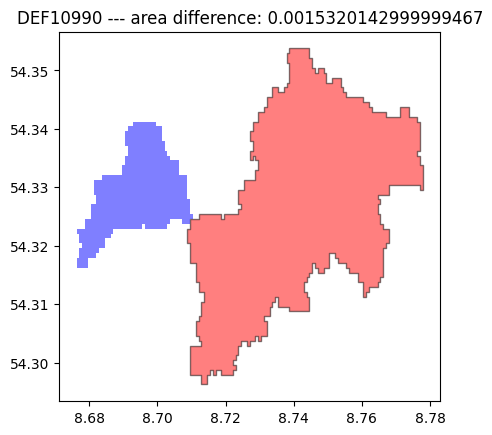

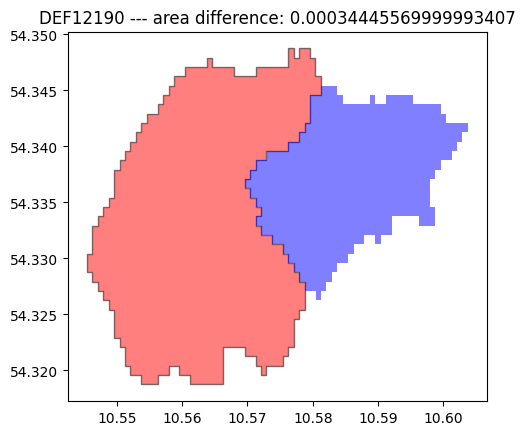

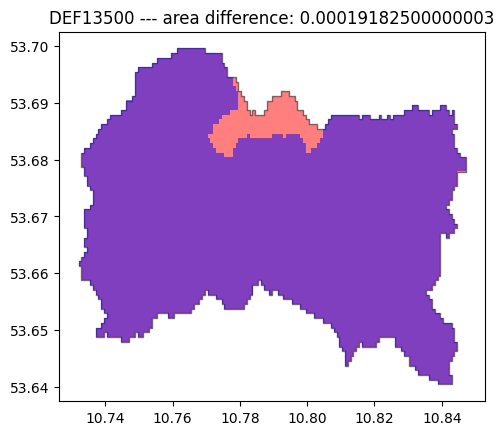

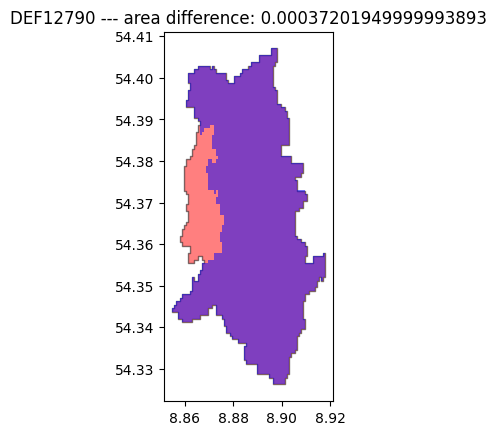

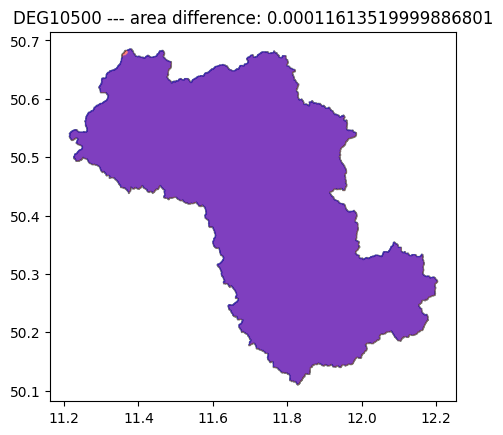

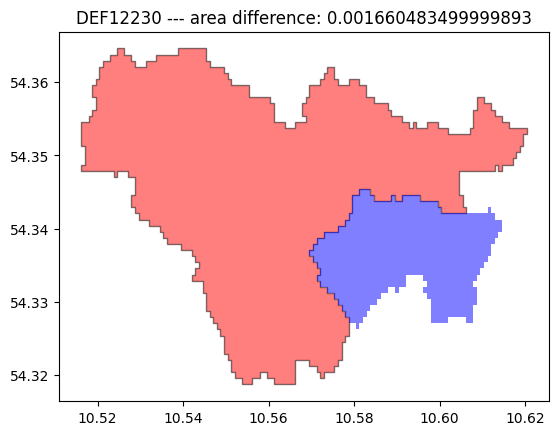

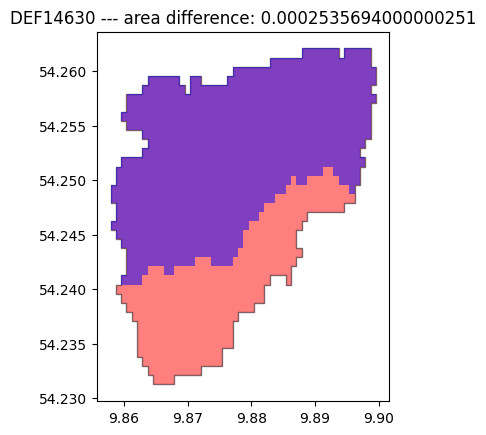

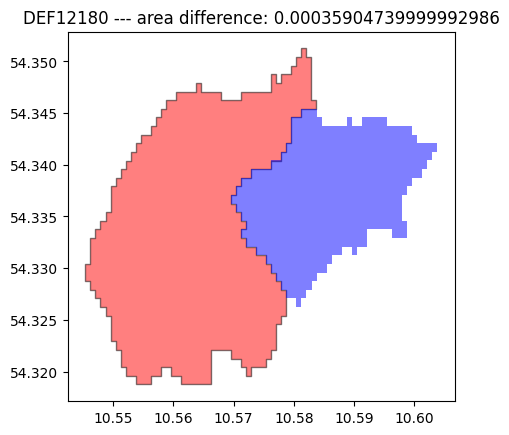

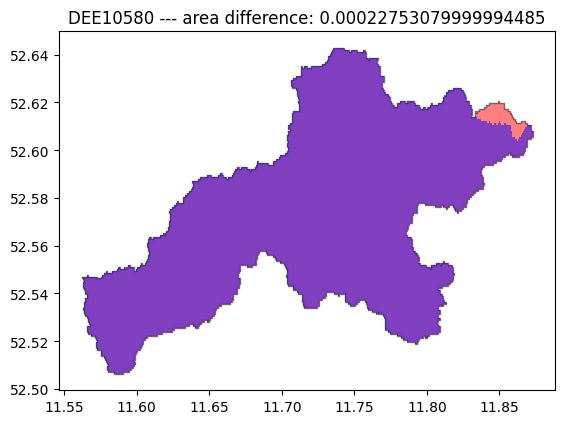

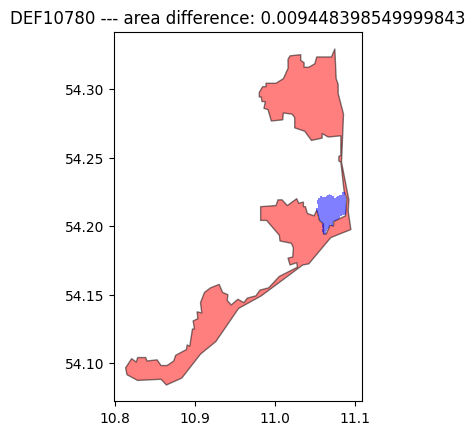

In [46]:
id = failed_ids[3]

for id in failed_ids:
    s = Station(id)

    # read api catchment
    gdf_api = gpd.read_file(f"../merit_hydro/api_results/{id}.geojson")
    # read merit hydro
    gdf_merit = s.get_catchment(datasource="merit_hydro")

    # calculate area difference
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        area_diff = gdf_api.area - gdf_merit.area
    if area_diff[0] > 0.0001:
        # plot both catchments
        ax = gdf_api.plot(color="red", edgecolor="black", alpha=0.5)
        gdf_merit.plot(ax=ax, color="blue", edgecolor="none", alpha=0.5)
        # add title
        ax.set_title(f"{id} --- area difference: {area_diff[0]}")


## API are results can be different!

Maybe we stick to the scrip method from Github...  
Even if the API is easier to use.